In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms

import zipfile

import shutil
import os
import pandas as pd

print(torch.cuda.is_available())
device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

True


In [2]:
#架設AlexNet Model
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        
        self.convolutional = nn.Sequential(
            #C1
            nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #C2
            nn.Conv2d(64,192,kernel_size=5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #C3
            nn.Conv2d(192,384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            #C4
            nn.Conv2d(384,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            #C5
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096,2),
        )
        
    def forward(self,x):
        x=self.convolutional(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1)
        x=self.linear(x)

        return torch.sigmoid(x)

In [3]:
model = AlexNet()
model = model.to(device)

In [4]:
#如果載過可以先"""起來
"""
!mkdir data_faces #建設一個資料夾來放需要的資料集
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip #如果覺得太慢可以直接去網址下載
with zipfile.ZipFile("celeba.zip","r") as zip_ref: #解壓縮
    zip_ref.extractall("data_faces/")
"""

'\n!mkdir data_faces #建設一個資料夾來放需要的資料集\n!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip #如果覺得太慢可以直接去網址下載\nwith zipfile.ZipFile("celeba.zip","r") as zip_ref: #解壓縮\n    zip_ref.extractall("data_faces/")\n'

In [5]:
img_list = os.listdir('data_faces/img_align_celeba') #celeba總共有202599張照片
print(len(img_list))

202599


In [6]:
df = pd.read_csv("list_attr_celeba.csv") #這個csv要自己去網路上下載https://www.kaggle.com/jessicali9530/celeba-dataset
df = df[['image_id','Smiling']] #csv裡面有包含很多照片的訊息，只取照片id跟是否有笑
df

,image_id,Smiling
0,000001.jpg,1
1,000002.jpg,1
2,000003.jpg,-1
3,000004.jpg,-1
4,000005.jpg,-1
...,...,...
202594,202595.jpg,-1
202595,202596.jpg,1
202596,202597.jpg,1
202597,202598.jpg,1


In [7]:
#建立資料夾
!mkdir data
!mkdir data/smile
!mkdir data/no_smile

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/smile’: File exists
mkdir: cannot create directory ‘data/no_smile’: File exists


In [8]:
#這次訓練只用有笑1500張,不笑1500張
num = 1500
num_smile,num_nosmile=0,0

#開始把照片分開放到不同資料夾
for i, (_, i_row) in enumerate(df.iterrows()):
    if num_smile < num:
        if i_row['Smiling'] == 1:
            num_smile += 1
            shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'],
                            'data/smile/' + i_row['image_id'])
    if num_nosmile < num:
        if i_row['Smiling'] == -1:
            num_nosmile += 1
            shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'],
                            'data/no_smile/' + i_row['image_id'])

Images:  3000


In [10]:
!rm -rf 'data/.ipynb_checkpoints/' #刪除checkpoints,避免再修正完程式碼後有沒有刪的東西

In [11]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

celeba_data = datasets.ImageFolder('data',transform=transform)

print(celeba_data.classes)
print(len(celeba_data))

['no_smile', 'smile']
3000


In [12]:
img_list = os.listdir('data/smile')    #先把照片的數量存起來
img_list.extend(os.listdir('data/no_smile'))
print("Images: ",len(img_list))

train_size = int(len(img_list)*0.75)  #訓練集為75%
test_size = len(img_list) - train_size #測試集為100%-75%也就是25%

train_set, test_set = torch.utils.data.random_split(celeba_data,[train_size, test_size]) #開始分訓練集跟測試集

trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True) #打包成64組一包
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True) #打包成64組一包

print(train_size) #訓練集的張數
print(test_size) #訓練集的張數

2250
750


In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.0001) #設定優化器
criterion = nn.CrossEntropyLoss() #設定loss函數
epochs = 20  #設定迭代次數
train_loss = []


model.train() #要訓練就要先開啟訓練模式
for epoch in range(epochs):
    
    total_train_loss = 0
    
    for idx,(image,label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)
        
        #################################  pytorch的訓練都幾乎這樣寫
        optimizer.zero_grad()           #
        pred = model(image)             #
                                        #
        loss = criterion(pred,label)    #
        total_train_loss += loss.item() #
                                        #
        loss.backward()                 #
        optimizer.step()                #
        #################################
        
    total_train_loss = total_train_loss / (idx+1)
    train_loss.append(total_train_loss) #把loss存起來 等等才能畫出來
    print(f'Epoch: {epoch} | Train Loss: {total_train_loss}')

Epoch: 0 | Train Loss: 0.6937802235285441
Epoch: 1 | Train Loss: 0.6932869950930277
Epoch: 2 | Train Loss: 0.6931411888864305
Epoch: 3 | Train Loss: 0.6894292102919685
Epoch: 4 | Train Loss: 0.6920495811435912
Epoch: 5 | Train Loss: 0.6861212717162238
Epoch: 6 | Train Loss: 0.677327854765786
Epoch: 7 | Train Loss: 0.6769772354099486
Epoch: 8 | Train Loss: 0.6549901862939199
Epoch: 9 | Train Loss: 0.6444289618068271
Epoch: 10 | Train Loss: 0.6260743141174316
Epoch: 11 | Train Loss: 0.6257730457517836
Epoch: 12 | Train Loss: 0.5928611987166934
Epoch: 13 | Train Loss: 0.6002772765027152
Epoch: 14 | Train Loss: 0.5720399601591958
Epoch: 15 | Train Loss: 0.5420249816444185
Epoch: 16 | Train Loss: 0.5249331494172415
Epoch: 17 | Train Loss: 0.4986695738302337
Epoch: 18 | Train Loss: 0.4788219788008266
Epoch: 19 | Train Loss: 0.45172884315252304


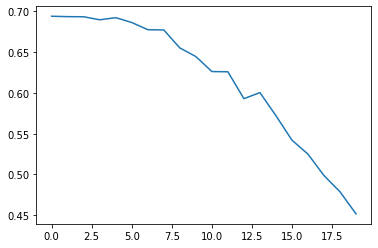

In [14]:
#劃出訓練過程的loss
plt.plot(train_loss)

In [15]:
#製作測試集
testiter = iter(testLoader)
images, labels = testiter.next()

#跑測試集預測
with torch.no_grad():
    model.eval()
    images, labels = images.to(device), labels.to(device)
    pred = model(images)

In [16]:
images_np = [i.cpu() for i in images] #把圖片轉成矩陣
class_names = celeba_data.classes  #儲存['no_smile', 'smile']兩個標籤東西
print(class_names)


['no_smile', 'smile']


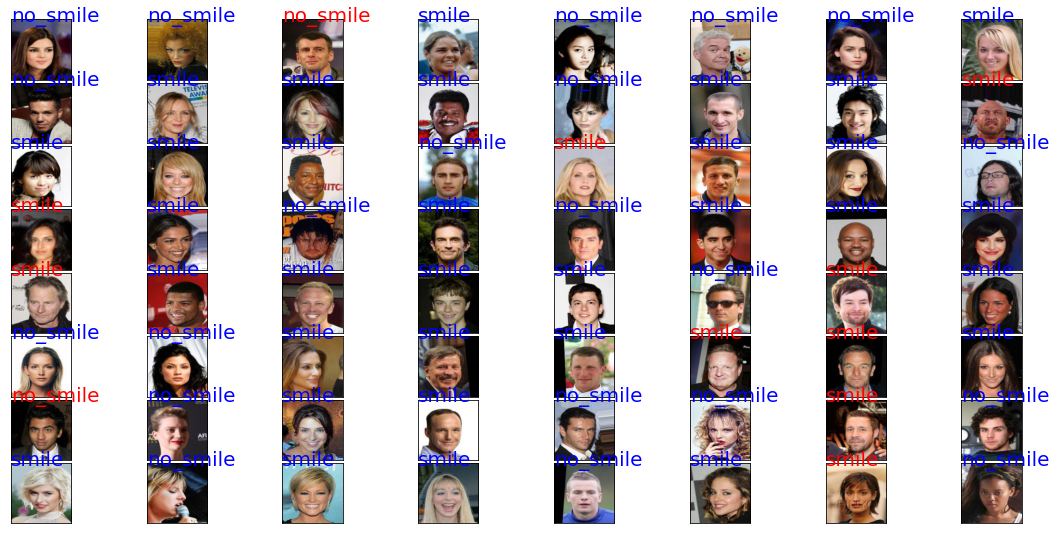

In [17]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i].permute(1,2,0)) 
    #permute為根據原本[0][1][2]的大小排成需要的樣子
    #像是images_np[i]為(3,256,256)經(1,2,0)轉換後會變成(256,256,3)

    if labels[i] == torch.max(pred[i], 0)[1]: #torch.max 出來會有兩組數字，取第1組才是預測出來的標籤
        ax.text(0, 8, class_names[torch.max(pred[i], 0)[1]], color='blue',size=20)
    else:
        ax.text(0, 8, class_names[torch.max(pred[i], 0)[1]], color='red',size=20)

tensor([[2.4580e-04, 9.9967e-01]], device='cuda:0')
有笑


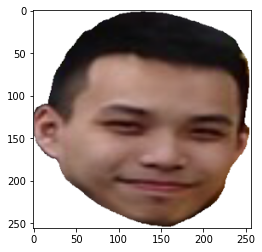

In [28]:
#測試自己的單張圖片
from PIL import Image
import torchvision.transforms as T
from torch.autograd import Variable as V
import torch as t

#讀入圖片
img = Image.open('data/惟澤.png')  #換另一張 瑞宏.png
img = img.resize((256, 256))
plt.imshow(img)

transf = transforms.ToTensor()
iminput = transf(img)  # tensor数据格式是torch(C,H,W)

iminput = iminput.unsqueeze(0)#增加一維，輸出的img格式爲[1,C,H,W]

with torch.no_grad():
    model.eval()
    iminput = V(iminput.cuda())
    pred = model(iminput)#將圖片輸入網絡得到輸出
    print(pred)
    if torch.max(pred[0],0)[1] == 1:
        print("有笑")
    else:
        print("沒笑")
    

